# Twitter Sentiment Analysis

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [20]:


# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

"""# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)"""

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [21]:
df = pd.read_csv("/content/drive/MyDrive/SIT-AstonHackathon/FinalDisasterTweets.csv")

In [22]:
print("Dataset size:", len(df))

Dataset size: 41998


In [23]:
df.head(5)

,num,text,timestamp,label
0,0.0,RT @uberdogfound: Please RT - Food needed for ...,40657.975,1
1,1.0,Please RT - Food needed for shelter in NC in a...,40657.975,1
2,3.0,‚ô°its raining and tornado warnings....about t...,40657.89792,1
3,9.0,Lmao #damn RT @LuCeCaNNoNn: If I don't get any...,40657.76667,1
4,10.0,Saved by the tornado warning....I'm just ready...,40657.75625,0


### Map target label to String
* **0** -> **Positive**
* **1** -> **Negative**

In [24]:
"""decode_map = {0: "Positive", 1: "Negative"}
def decode_sentiment(label):
    return decode_map[int(label)]"""

'decode_map = {0: "Positive", 1: "Negative"}\ndef decode_sentiment(label):\n    return decode_map[int(label)]'

In [25]:
"""%%time
df.label = df.label.apply(lambda x: decode_sentiment(x))"""

'%%time\ndf.label = df.label.apply(lambda x: decode_sentiment(x))'

Text(0.5, 1.0, 'Dataset labels distribuition')

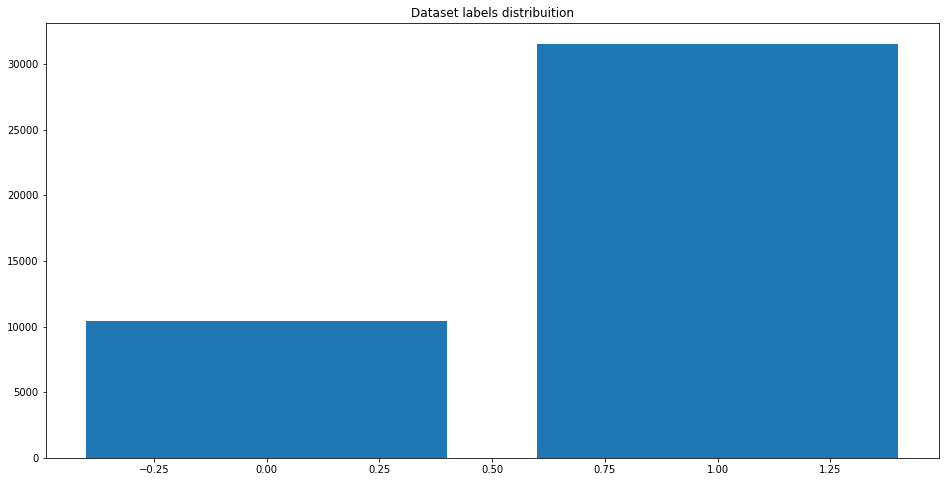

In [26]:
target_cnt = Counter(df.label)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Split train and test

In [27]:
df_train, df_test = train_test_split(df, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
df_test1=df_test

TRAIN size: 33598
TEST size: 8400


### Pre-Process dataset

In [28]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [29]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [30]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

CPU times: user 2.88 s, sys: 13.6 ms, total: 2.89 s
Wall time: 2.91 s


### Word2Vec 

In [31]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 265 ms, sys: 29 ms, total: 294 ms
Wall time: 297 ms


In [32]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [33]:
w2v_model.build_vocab(documents)

2022-05-17 15:48:07,233 : INFO : collecting all words and their counts
2022-05-17 15:48:07,239 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-17 15:48:07,300 : INFO : PROGRESS: at sentence #10000, processed 133207 words, keeping 15255 word types
2022-05-17 15:48:07,353 : INFO : PROGRESS: at sentence #20000, processed 267169 words, keeping 22478 word types
2022-05-17 15:48:07,401 : INFO : PROGRESS: at sentence #30000, processed 399663 words, keeping 28117 word types
2022-05-17 15:48:07,418 : INFO : collected 29849 word types from a corpus of 446933 raw words and 33598 sentences
2022-05-17 15:48:07,419 : INFO : Loading a fresh vocabulary
2022-05-17 15:48:07,451 : INFO : effective_min_count=10 retains 4187 unique words (14% of original 29849, drops 25662)
2022-05-17 15:48:07,452 : INFO : effective_min_count=10 leaves 396916 word corpus (88% of original 446933, drops 50017)
2022-05-17 15:48:07,469 : INFO : deleting the raw counts dictionary of 29849 item

In [34]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 4187


In [35]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-05-17 15:48:08,504 : INFO : training model with 8 workers on 4187 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-05-17 15:48:09,277 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-05-17 15:48:09,353 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-05-17 15:48:09,365 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-05-17 15:48:09,385 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-05-17 15:48:09,396 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-05-17 15:48:09,411 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-05-17 15:48:09,416 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-05-17 15:48:09,417 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-05-17 15:48:09,421 : INFO : EPOCH - 1 : training on 446933 raw words (329784 effective words) took 0.9s, 367840 effect

CPU times: user 52.3 s, sys: 476 ms, total: 52.8 s
Wall time: 31.6 s


(10553246, 14301856)

In [36]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-05-17 15:48:40,072 : INFO : precomputing L2-norms of word weight vectors


[('awesome', 0.4087464213371277),
 ('beautiful', 0.3868289589881897),
 ('fashion', 0.37496834993362427),
 ('amazing', 0.36070775985717773),
 ('enjoy', 0.35988909006118774),
 ('lovely', 0.3551103174686432),
 ('honestly', 0.3549395501613617),
 ('jesus', 0.34826433658599854),
 ('billboard', 0.3452059030532837),
 ('sad', 0.34517067670822144)]

### Tokenize Text

In [37]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 29850
CPU times: user 727 ms, sys: 77.3 ms, total: 804 ms
Wall time: 747 ms


In [38]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 788 ms, sys: 22.9 ms, total: 811 ms
Wall time: 818 ms


### Label Encoder 

In [39]:
labels = df_train.label.unique().tolist()

labels

[1, 0]

In [40]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (33598, 1)
y_test (8400, 1)


In [41]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (33598, 300)
y_train (33598, 1)

x_test (8400, 300)
y_test (8400, 1)


In [42]:
y_train[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]])

### Embedding layer

In [43]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(29850, 300)


In [44]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          8955000   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 9,115,501
Trainable params: 160,501
Non-trainable params: 8,955,000
_________________________________________________________________


### Compile model

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [47]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
18/30 [=================>............] - ETA: 2:43 - loss: 0.5708 - accuracy: 0.7215

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:


def decode_sentiment(score):
  if score >= 0.5:
    label = 0
  elif score <= 0.5:
    label =1

  return label  
    

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.label)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.label.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### F1 Score

In [ ]:
import sklearn.metrics
sklearn.metrics.f1_score(y_test_1d, y_pred_1d)

### Save Results

In [ ]:
y_test_1d=pd.DataFrame(y_test_1d)
y_test_1d.shape

In [ ]:
y_pred_1d=pd.DataFrame(y_pred_1d)
y_pred_1d.shape

In [ ]:
df_test1=pd.DataFrame(df_test1)
df_test1.shape

In [ ]:

result=pd.concat([df_test,y_test_1d, y_pred_1d], join='outer', axis=1)
result.columns=['Text','Ground Truth', 'Predictions']
result